# Hearthstone Deck Recommendation
### Objetivo: Construir un mazo ganador para una partida de Hearthstone.

## Librerias

In [5]:
import json
import time
import keras
import pickle
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
from collections import Counter

rd.seed(3633)

## Base de datos
La base de datos se obtuvo de la plataforma HearthPwn (https://www.hearthpwn.com/decks), esta contiene información sobre mazos creados por jugadores de Hearthstone. Los datos incluyen la clase del mazo, sus 30 cartas, el coste de creación, la puntuación, entre otros, pero dentro de las columnas más importantes está el rating que asignaron múltiples jugadores en la plataforma.

In [2]:
df = pd.read_csv("data/data.csv")
df.head()

,craft_cost,date,deck_archetype,deck_class,deck_format,deck_id,deck_set,deck_type,rating,title,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
0,9740,2016-02-19,Unknown,Priest,W,433004,Explorers,Tavern Brawl,1,Reno Priest,...,374,2280,2511,2555,2566,2582,2683,2736,2568,2883
1,9840,2016-02-19,Unknown,Warrior,W,433003,Explorers,Ranked Deck,1,RoosterWarrior,...,1781,1781,2021,2021,2064,2064,2078,2510,2729,2736
2,2600,2016-02-19,Unknown,Mage,W,433002,Explorers,Theorycraft,1,Annoying,...,1793,1801,1801,2037,2037,2064,2064,2078,38710,38710
3,15600,2016-02-19,Unknown,Warrior,W,433001,Explorers,NaN,0,Standart pay to win warrior,...,1657,1721,2018,2296,2262,336,2729,2729,2736,2760
4,7700,2016-02-19,Unknown,Paladin,W,432997,Explorers,Ranked Deck,1,Palamix,...,2027,2029,2029,2064,2078,374,2717,2717,2889,2889


In [3]:
df.describe()

,craft_cost,deck_id,rating,card_0,card_1,card_2,card_3,card_4,card_5,card_6,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
count,346232.000000,346232.000000,346232.000000,346232.000000,346232.000000,346232.000000,346232.000000,346232.000000,346232.000000,346232.000000,...,346232.000000,346232.000000,346232.000000,346232.000000,346232.000000,346232.000000,346232.000000,346232.000000,346232.000000,346232.000000
mean,5645.360218,394152.425798,2.687230,166.555443,215.682814,328.068948,388.254399,465.439497,530.422084,618.649576,...,6676.817657,7879.285156,9310.508977,10780.480210,12401.890674,13709.898080,15068.109406,15955.823881,19239.277147,20537.999847
std,3927.986295,222605.617140,22.117751,515.546751,549.163776,609.109069,629.218897,710.534945,813.475129,987.250288,...,12610.593768,13750.165455,14885.066464,15862.422929,16731.209629,17295.441879,17766.351821,18039.395857,18567.676290,18686.462303
min,0.000000,18.000000,0.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
25%,2720.000000,216721.500000,1.000000,64.000000,75.000000,189.000000,237.000000,279.000000,304.000000,401.000000,...,1158.000000,1363.000000,1659.000000,1783.000000,1794.000000,1913.000000,2010.000000,2037.000000,2078.000000,2095.000000
50%,5000.000000,406046.500000,1.000000,138.000000,180.000000,285.000000,315.000000,415.000000,475.000000,559.000000,...,1940.000000,2029.000000,2061.000000,2078.000000,2275.000000,2488.000000,2577.000000,2682.000000,2901.000000,3015.000000
75%,7740.000000,590820.500000,1.000000,238.000000,285.000000,421.000000,476.000000,605.000000,643.000000,763.000000,...,2610.000000,2736.000000,2890.000000,2958.000000,38391.000000,38526.000000,38727.000000,38833.000000,38918.000000,39034.000000
max,48000.000000,749548.000000,4016.000000,41409.000000,41409.000000,41609.000000,41409.000000,41409.000000,41609.000000,41609.000000,...,41609.000000,41609.000000,41609.000000,41609.000000,41609.000000,41609.000000,41841.000000,42146.000000,42146.000000,42146.000000


In [4]:
df['deck_class'].value_counts()

deck_class
Mage       45306
Priest     44307
Paladin    42266
Warlock    38022
Druid      37891
Shaman     36457
Warrior    35944
Rogue      34794
Hunter     31245
Name: count, dtype: int64

La clase de mazo con más entradas es "Mage". Para la implementación del sistema de recomendación utilizaremos solo mazos mago.

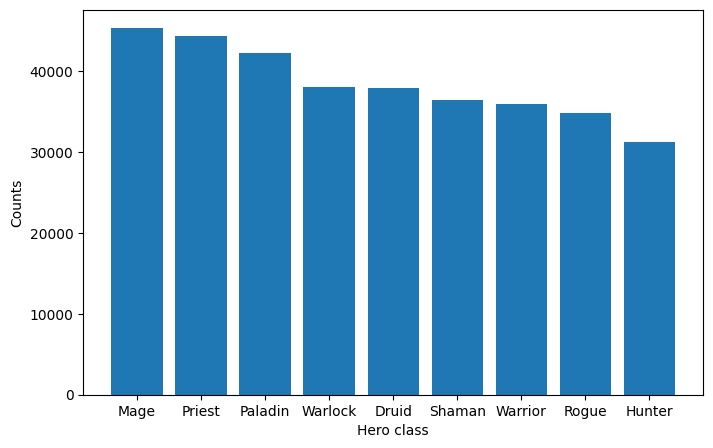

In [13]:
value_counts = df['deck_class'].value_counts()

# Plot the histogram
plt.figure(figsize=(8,5))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Hero class')
plt.ylabel('Counts')
plt.show()

In [3]:
df = df[df['deck_class'] == 'Mage']

## Cartas y mazos
Definimos el conjunto *cards* con las *N* cartas más repetidas en los mazos mago y *D* como el tamaño del mazo para armar.

In [4]:
cards_cols = df.iloc[:, 11:41] # columnas con las cartas en la base de datos
all_cards = (cards_cols.values.ravel()).tolist() # lista con las cartas
counter = Counter(all_cards) # contador de las cartas

N = len(counter) # tamaño conjunto cartas para elegir
cards =  [item[0] for item in counter.most_common(N)] # conjunto con las N cartas más repetidas

D = 30 # tamaño mazo Hearthstone

El mazo lo definimos como un vector binario *deck* con *N* entradas y exactamente *D* iguales a 1. Este vector nos indica con la i-esima entrada si está o no (1 o 0) en el mazo la i-esima carta de *cards*. Definimos la función *binary_to_cards* que transforma el vector *deck* en una lista con la enumeración de las cartas del mazo. A continación se presenta un ejemplo de mazos.

In [5]:
def binary_to_cards(deck, cards):
    return [int(x) for x in deck*cards if x != 0]

In [6]:
deck = np.zeros(N, dtype=int) # definir mazo jugador
deck[np.random.choice(N, D, replace=False)] = 1 # generar mazo aleatorio jugador
print(f'Vector mazo: {deck}')
print(f'Cartas mazo: {binary_to_cards(deck, cards)}')

Vector mazo: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0

## Transiciones y acciones
El proceso para mejorar el mazo *deck* consta de aplicar múltiples veces la función de transición *transition* determinada por una acción. Una acción *action* es una tupla con las cartas del reemplazo que modifica exactamente una carta del mazo por una carta que actualmente no está incluida. A continuación, un ejemplo del uso de la función *transition*, en donde se elige de forma aleatoria la acción.

In [7]:
def transition(deck, action):
    deck[action[0]] = 0 # eliminamos la carta antigua del mazo
    deck[action[1]] = 1 # agregamos la carta nueva al mazo
    return deck

In [10]:
print(f'Mazo antiguo: {deck}')
print(f'Cartas mazo antiguo: {binary_to_cards(deck, cards)}')

old_card = np.random.choice(np.where(deck == 1)[0]) # elegimos aleatoriamente una carta que está en el mazo
new_card = np.random.choice(np.where(deck == 0)[0]) # elegimos aleatoriamente una carta que no está en el mazo
action = (old_card, new_card) # definimos la acción

print()
print(f'Acción: ({action[0]},{action[1]})')
print()

new_deck = transition(deck, action)
print(f'Mazo nuevo: {new_deck}')
print(f'Cartas mazo nuevo: {binary_to_cards(new_deck, cards)}')

Mazo antiguo: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 

## Win Rate
Para elegir las acciones que nos lleven a encontrar un mazo ganador usaremos el *win_rate* de este mazo. Entonces, para elegir la próxima acción buscaremos cual es la que maximiza el *win_rate* del mazo.

Para hacer una función predictora del *win_rate* entrenamos distintos modelos de machine learning, esto se realizó en el notebook *win_rate_prediction.ipynb*. A continuación, se importan estos modelos ya entrenados.

In [8]:
model = keras.models.load_model("win_rate_NN.keras") # importación modelo red neuronal
model_v1 = keras.models.load_model("win_rate_NNv1.keras")
model_v2 = keras.models.load_model("win_rate_NNv2.keras")
model_v3 = keras.models.load_model("win_rate_NNv3.keras")
#model.summary()

with open("encoder", "rb") as f:
    encoder = pickle.load(f)
with open("win_rate_RF.pkl", "rb") as f:
    rf = pickle.load(f) # importación modelo random forest

Ahora, definimos la función *win_rate* que recibe el mazo en el formato enumerado de cartas y dependiendo del modelo elegido entrega el valor del win rate.

In [9]:
def win_rate(deck, encoder = encoder, model = model):
  mazo_gen_num = pd.DataFrame([{f"card_{i}": (deck[i] if i>-1 else 5645) for i in range(-1,30)}]).rename(columns={"card_-1":"craft_cost"})
  hero = "Mage"
  mazo_gen_cat = pd.DataFrame([{"hero":hero}])
  encoded_categorical = encoder.transform(mazo_gen_cat)
  encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())
  final_df = pd.concat([mazo_gen_num, encoded_df], axis=1).rename(columns={"craft_cost":"dust"})
  if isinstance(model,keras.src.models.sequential.Sequential):
    results = model.predict(final_df,verbose=None)
  else:
    results = model.predict(final_df)
  if isinstance(results[0],np.ndarray):
    return results[0][0]
  else:
    return results[0]

Finalmente, imprimimos el win rate aproximado para el mazo *deck_p* usando los dos modelos. Primero en base a la red neuronal entrenada y después mediante un random forest.

In [13]:
print('Neural network:', win_rate(binary_to_cards(deck, cards))) # red neuronal
print('Random forest:', win_rate(binary_to_cards(deck, cards),model=rf)) # random forest
print('Neural network v1:', win_rate(binary_to_cards(deck, cards),model=model_v1)) # red neuronal
print('Neural network v2:', win_rate(binary_to_cards(deck, cards),model=model_v2)) # red neuronal
print('Neural network v3:', win_rate(binary_to_cards(deck, cards),model=model_v3)) # red neuronal


Neural network: 54.92001
Random forest: 50.51133333333337
Neural network v1: 31.473282
Neural network v2: 28.782068
Neural network v3: 37.498074


## Implementación 

Con la función de *win_rate* ya definida podemos decidir cual es la siguiente acción más conveniente a realizar. Vamos a comenzar con un mazo *deck* y realizar acciones hasta que ya no sea conveniente seguir modificando el mazo, estas serán a los más *D*, ya que a lo más cambiamos todo el mazo para encontrar el óptimo. A continuación, definimos la función *next_action* que a partir del mazo actual encuentra la siguiente acción más conveniente a realizar según el *win_rate*, incluyendo la acción de preservar el mazo igual.

In [13]:
def next_action(deck, cards):
    current_win_rate = win_rate(binary_to_cards(deck, cards),model=model_v3)
    best_win_rate = current_win_rate
    best_action = None
    
    zeros = [index for index, value in enumerate(deck) if value == 0]
    ones = [index for index, value in enumerate(deck) if value == 1]
     
    for zero in zeros:
        for one in ones: 
            temp_deck = deck.copy()  
            action = (one, zero)
            temp_deck = transition(temp_deck, action)
            temp_win_rate = win_rate(binary_to_cards(temp_deck, cards),model=model_v3)
            if temp_win_rate > best_win_rate:
                best_win_rate = temp_win_rate
                best_action = action
    
    return best_action    

Ahora con la función *deck_reck* podemos hacer efectiva la mejor acción sucesivamente hasta llegar a *D* acciones o haber generado un mazo óptimo.

In [11]:
def deck_rec(deck, cards):
    for i in range(D):
        action = next_action(deck, cards)
        if action == None:
            break
        else:
            deck = transition(deck, action)
    return deck

In [12]:
print(f'Mazo inicial: {binary_to_cards(deck, cards)}')
print(f'Win rate inicial: {win_rate(binary_to_cards(deck, cards))}')
new_deck = deck_rec(deck, cards)
print(f'Mazo final: {binary_to_cards(new_deck, cards)}')
print(f'Win rate final: {win_rate(binary_to_cards(new_deck, cards))}')

Mazo inicial: [2064, 1793, 113, 1016, 40297, 281, 40496, 753, 242, 2067, 38496, 834, 2520, 2581, 339, 2495, 38526, 1063, 2085, 67, 1109, 2049, 1791, 1800, 2074, 39313, 680, 39207, 40803, 39002]
Win rate inicial: 53.65727996826172


KeyboardInterrupt: 

## Comparación de resultados
### Distintos Métodos
Vamos a comparar nuestra implementación con los siguientes métodos.

1. Random:
Entrega de forma aleatoria un mazo de cartas de la base de datos.

In [15]:
def random_deck():
  row = df.sample(n=1)
  id = row['deck_id'].tolist()[0]
  cards_cols = row.iloc[:, 11:41]
  cards_list = (cards_cols.values.ravel()).tolist() 
  return id, cards_list

2. Most popular: 
Retorna el mazo con el mejor rating de la base de datos.

In [16]:
def most_popular_deck():
  row = df[df['rating'] == df['rating'].max()]
  cards_cols = row.iloc[:, 11:41]
  cards_list = (cards_cols.values.ravel()).tolist() 
  return cards_list

3. Best Similar:
Recibe un mazo y retorna un mazo similar de la base de datos con mejor rating. 

Para definir la similitud, se implementó una función *difference* que calcula la cantidad de cartas diferentes entre los mazos. De esta forma, el modelo también recibe como parámetro un *delta* que define la máxima posible diferencia entre el mazo retornado y el original.

In [17]:
def difference(deck_1, deck_2):
  common = len(np.intersect1d(deck_1, deck_2))
  diff = len(deck_1) - common
  return diff

def best_similar_deck(my_deck, delta):
  best_decks = df[df['rating'] > 2]
  best_deck_id = -1
  best_deck_rating = -1
  for index, row in best_decks.iterrows():
    new_deck_id = row['deck_id']
    new_deck_rating = row['rating']
    deck_2 = df[df['deck_id'] == new_deck_id].iloc[:, 11:41].values.flatten()
    if difference(my_deck, deck_2) <= delta:
      if new_deck_rating >= best_deck_rating:
        best_deck_id = new_deck_id
        best_deck_rating = new_deck_rating
  if best_deck_id>=0:
    row = df[df['deck_id'] == best_deck_id]
    cards_cols = row.iloc[:, 11:41]
    cards_list = (cards_cols.values.ravel()).tolist() 
    return cards_list
  else:
    return my_deck

Entonces, a continuación vamos a seleccionar de forma aleatoria un mazo de la base de datos y vamos a comparar los distintos sistemas recomendadores usando el *win_rate*.

In [58]:
original_id, original_deck = random_deck() # generamos mazo aleatorio
print(f'Mazo inicial: {original_deck}')
print(f'Win rate inicial: {win_rate(original_deck,model=model_v3)}')

Mazo inicial: [77, 113, 113, 315, 315, 395, 395, 531, 555, 555, 581, 662, 662, 1004, 1186, 1721, 1793, 1793, 1808, 1808, 1927, 1927, 1928, 1928, 2044, 2044, 2078, 374, 38710, 38710]
Win rate inicial: 27.771785736083984


In [64]:
id_random, deck_random = random_deck() # generamos recomendación aleatoria
print(f'Recomendación random: {deck_random}')
print(f'Win rate random: {win_rate(deck_random,model=model_v3)}')

Recomendación random: [77, 113, 192, 195, 195, 286, 315, 315, 366, 366, 621, 621, 662, 662, 748, 748, 1004, 1080, 1087, 1737, 1737, 1783, 1783, 1801, 1927, 1927, 2037, 2057, 38710, 38710]
Win rate random: 29.248106002807617


In [65]:
deck_most_popular = most_popular_deck() # generamos recomendación más popular
print(f'Recomendación más popular: {deck_most_popular}')
print(f'Win rate más popular: {win_rate(deck_most_popular,model=model_v3)}')

Recomendación más popular: [77, 315, 315, 405, 405, 555, 564, 564, 614, 635, 662, 662, 825, 825, 1004, 38547, 38547, 38725, 38725, 38857, 38859, 38859, 38863, 38863, 38868, 38868, 38900, 38900, 39715, 39715]
Win rate más popular: 34.774356842041016


In [66]:
id_random, deck_random = random_deck()
deck_best_similar = best_similar_deck(deck_random, 25) # generamos recomendación mejor similar
print(f'Recomendación mejor similar: {deck_best_similar}')
print(f'Win rate mejor similar: {win_rate(deck_best_similar,model=model_v3)}')

Recomendación mejor similar: [77, 315, 315, 405, 405, 555, 564, 564, 614, 635, 662, 662, 825, 825, 1004, 38547, 38547, 38725, 38725, 38857, 38859, 38859, 38863, 38863, 38868, 38868, 38900, 38900, 39715, 39715]
Win rate mejor similar: 34.774356842041016


In [ ]:
N=40 # Este N se utiliza solo en esta celda, para el resto se debe usar el original N=len(counter)
deck = np.zeros(N, dtype=int)
for i in range(N):
    for card in original_deck:
        if card == cards[i]:
            deck[i] = 1
zeros = [index for index, value in enumerate(deck) if value == 0]
ones = [index for index, value in enumerate(deck) if value == 1]
new_ones = rd.sample(zeros,D-len(ones))
for i in new_ones:
    deck[i] = 1
cards_subset = cards[:N]
deck_our_rec = deck_rec(deck,cards_subset)
print(f'Nuestra recomendación : {binary_to_cards(deck_our_rec, cards_subset)}')
print(f'Win rate nuestra recomendación: {win_rate(binary_to_cards(deck_our_rec, cards_subset),model=model_v3)}')

Nuestra recomendación : [662, 315, 555, 1004, 77, 825, 1783, 395, 1084, 38710, 172, 2874, 1659, 1927, 1793, 113, 2875, 1928, 430, 1087, 2050, 2078, 581, 1940, 39715, 374, 2070, 1721, 906, 2883]
Win rate nuestra recomendación: 31.558528900146484


In [18]:
def next_action_restricted(deck, cards, fixed):
    current_win_rate = win_rate(binary_to_cards(deck, cards),model=model_v3)
    best_win_rate = current_win_rate
    best_action = None
    zeros = [index for index, value in enumerate(deck) if ((value == 0) and (index not in fixed))]
    ones = [index for index, value in enumerate(deck) if ((value == 1) and (index not in fixed))]
    for zero in zeros:
        for one in ones: 
            temp_deck = deck.copy()  
            action = (one, zero)
            temp_deck = transition(temp_deck, action)
            temp_win_rate = win_rate(binary_to_cards(temp_deck, cards),model=model_v3)
            if temp_win_rate > best_win_rate:
                best_win_rate = temp_win_rate
                best_action = action
    
    return best_action   

def Qdeck_wtemplate(my_deck, delta, gamma,N=40):
    cards_list = best_similar_deck(my_deck, delta)
    deck = np.zeros(N, dtype=int)
    for i in range(N):
        for card in cards_list:
            if card == cards[i]:
                deck[i] = 1
    zeros = [index for index, value in enumerate(deck) if value == 0]
    ones = [index for index, value in enumerate(deck) if value == 1]
    new_ones = rd.sample(zeros,D-len(ones))
    fixed_c = rd.sample(np.arange(N).tolist(),gamma)
    for i in new_ones:
        deck[i] = 1
    zeros = [i for i in zeros if i not in fixed_c]
    ones = [i for i in ones if i not in fixed_c]
    cards_subset = cards[:N]
    for i in range(D-len(fixed_c)):
        action = next_action(deck, cards_subset)
        if action == None:
            break
        else:
            deck = transition(deck, action)
    return deck



In [106]:
cards_subset = cards[:40]

In [ ]:
deck_qdecktemp = Qdeck_wtemplate(original_deck, 20, 20)
print(f'Recomendación qdeck con templates: {binary_to_cards(deck_qdecktemp, cards_subset)}')
print(f'Win rate qdeck con templates: {win_rate(binary_to_cards(deck_qdecktemp, cards_subset),model=model_v3)}')

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 0
 1 1 1]
Recomendación qdeck con templates: [662, 315, 555, 1004, 405, 614, 77, 825, 564, 1783, 395, 457, 2275, 1084, 587, 195, 172, 621, 138, 2064, 1801, 1927, 1793, 2572, 2262, 113, 1928, 1087, 2050, 2078]
Win rate qdeck con templates: 51.95368576049805


Observamos que de los sistemas recomendadores anteriores el que entrega el mazo con un mejor *win rate* es el nuestro.
### Distintos mazos
Ahora, vamos a implementar lo anterior para múltiples mazos aleatorios y volver a comparar. En particular hacemos una prueba para 20 mazos iniciales, con el fin de comparar la mejora relacionada al mazo final obtenido con cada método.

In [25]:
simulations = {"initial":[], "random":[],"MP":[],"BS":[],"DeckReck":[],"templateDeckReck":[]}
N = 40
for i in range(10):
    initial_deck = random_deck()[1]
    simulations["initial"].append(win_rate(initial_deck,model=model_v3))
    # random
    simulations["random"].append(win_rate(random_deck()[1],model=model_v3))
    # most popular 
    simulations["MP"].append(win_rate(most_popular_deck(),model=model_v3))
    # best similar
    simulations["BS"].append(win_rate(best_similar_deck(initial_deck, 20),model=model_v3))
    # Qdeck con template
    deck_qdecktemp = Qdeck_wtemplate(initial_deck, 20, 20,N = N)
    cards_subset = cards[:N]
    simulations["templateDeckReck"].append(win_rate(binary_to_cards(deck_qdecktemp, cards_subset),model=model_v3))
    deck = np.zeros(N, dtype=int)
    for i in range(N):
        for card in initial_deck:
            if card == cards[i]:
                deck[i] = 1
    zeros = [index for index, value in enumerate(deck) if value == 0]
    ones = [index for index, value in enumerate(deck) if value == 1]
    new_ones = rd.sample(zeros,D-len(ones))
    for i in new_ones:
        deck[i] = 1
    cards_subset = cards[:N]
    deck_our_rec = deck_rec(deck,cards_subset)
    simulations["DeckReck"].append(win_rate(binary_to_cards(deck_our_rec, cards_subset),model=model_v3))

In [26]:
# esta celda es utilizada únicamente para un guardado de resultados en un formato cómodo
print(simulations["initial"])
sim_fl = dict()
for key in simulations.keys():
    sim_fl[key] = [float(simulations[key][i]) for i in range(len(simulations[key]))]

[np.float32(28.11092), np.float32(38.204815), np.float32(50.43181), np.float32(27.33623), np.float32(49.18761), np.float32(30.870209), np.float32(48.97862), np.float32(29.248104), np.float32(30.183279), np.float32(40.741096)]


In [27]:
#guardando resultados
with open('comparacion_modelos.json', 'w') as json_file:
    json.dump(sim_fl, json_file, indent=4)

vemos los resultados para cada intento

In [28]:
comparacion = pd.DataFrame(sim_fl)
comparacion#.describe()

,initial,random,MP,BS,DeckReck,templateDeckReck
0,28.110920,51.102776,34.774357,30.716143,53.167156,52.784203
1,38.204815,51.501720,34.774357,34.774357,53.305771,53.702938
2,50.431808,30.246023,34.774357,49.248680,53.560356,53.105717
3,27.336229,51.502987,34.774357,30.716143,52.765369,54.913013
4,49.187611,31.033617,34.774357,30.716143,53.459522,53.308113
5,30.870209,29.248104,34.774357,34.774357,52.553825,53.451199
6,48.978619,28.978743,34.774357,30.716143,53.204258,54.093781
7,29.248104,51.051846,34.774357,28.185167,53.582363,53.058144
8,30.183279,29.453979,34.774357,36.115280,53.115856,53.058094
9,40.741096,29.598967,34.774357,34.774357,53.806332,52.765366


In [29]:
aumentos = pd.DataFrame({"random":comparacion["random"]/comparacion["initial"],
                         "MP": comparacion["MP"]/comparacion["initial"],
                         "BS": comparacion["BS"]/comparacion["initial"],
                         "DeckReck": comparacion["DeckReck"]/comparacion["initial"],
                         "temp_DeckReck": comparacion["templateDeckReck"]/comparacion["initial"]})
aumentos

,random,MP,BS,DeckReck,temp_DeckReck
0,1.817898,1.237041,1.092677,1.891335,1.877712
1,1.348043,0.910209,0.910209,1.395263,1.405659
2,0.599741,0.689532,0.976540,1.062035,1.053020
3,1.884056,1.272098,1.123642,1.930236,2.008800
4,0.630923,0.706974,0.624469,1.086849,1.083771
5,0.947454,1.126470,1.126470,1.702412,1.731482
6,0.591661,0.709991,0.627134,1.086275,1.104437
7,1.745475,1.188944,0.963658,1.831994,1.814071
8,0.975838,1.152107,1.196533,1.759778,1.757864
9,0.726514,0.853545,0.853545,1.320689,1.295139


el dataframe aumentos representa la mejora porcentual de cada método y sus estadísticas están dadas por el describe a continuación. 

In [30]:
aumentos.describe()

,random,MP,BS,DeckReck,temp_DeckReck
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.126760,0.984691,0.949488,1.506687,1.513195
std,0.527889,0.235368,0.201223,0.354851,0.364980
min,0.591661,0.689532,0.624469,1.062035,1.053020
25%,0.654821,0.745879,0.867711,1.145309,1.152112
50%,0.961646,1.018339,0.970099,1.548838,1.568570
75%,1.646117,1.179735,1.115901,1.813940,1.800019
max,1.884056,1.272098,1.196533,1.930236,2.008800


### Distintos parámetros

a continuación probamos variando el parámetro delta del método de Best most similar

In [32]:
simulations_delta = {"initial":[], "25":[],"20":[],"15":[],"10":[]}
for i in range(20):
    initial_deck = random_deck()[1]
    simulations_delta["initial"].append(win_rate(initial_deck,model=model_v3))
    simulations_delta["25"].append(win_rate(best_similar_deck(initial_deck, 25),model=model_v3))
    simulations_delta["20"].append(win_rate(best_similar_deck(initial_deck, 20),model=model_v3))
    simulations_delta["15"].append(win_rate(best_similar_deck(initial_deck, 15),model=model_v3))
    simulations_delta["10"].append(win_rate(best_similar_deck(initial_deck, 10),model=model_v3))
print(simulations["initial"])
sim_delta_fl = dict()
for key in simulations_delta.keys():
    sim_delta_fl[key] = [float(simulations_delta[key][i]) for i in range(len(simulations_delta[key]))]
with open('comparacion_delta.json', 'w') as json_file:
    json.dump(sim_delta_fl, json_file, indent=4)
comparacion_delta = pd.DataFrame(simulations_delta)
comparacion_delta

[np.float32(28.11092), np.float32(38.204815), np.float32(50.43181), np.float32(27.33623), np.float32(49.18761), np.float32(30.870209), np.float32(48.97862), np.float32(29.248104), np.float32(30.183279), np.float32(40.741096)]


,initial,25,20,15,10
0,28.907530,34.774357,28.907530,28.907530,28.907530
1,31.557219,50.310116,50.310116,31.557219,31.557219
2,50.600479,34.774357,50.408131,50.600479,50.600479
3,32.220821,34.774357,28.185167,29.248104,32.220821
4,29.009476,34.774357,30.716143,29.598967,29.009476
5,50.240791,27.866520,47.852882,46.456707,50.240791
6,27.866520,34.774357,29.248104,27.866520,27.866520
7,29.520218,34.774357,28.185167,28.185167,29.520218
8,33.788162,34.774357,36.115280,33.788162,33.788162
9,50.179607,50.310116,51.291206,50.179607,50.179607


In [33]:
aumentos_delta = pd.DataFrame({"25":comparacion_delta["25"]/comparacion_delta["initial"],
                         "20": comparacion_delta["20"]/comparacion_delta["initial"],
                         "15": comparacion_delta["15"]/comparacion_delta["initial"],
                         "10": comparacion_delta["10"]/comparacion_delta["initial"]})
aumentos_delta.describe()

,25,20,15,10
count,20.000000,20.000000,20.000000,20.0
mean,1.048471,1.028339,0.982779,1.0
std,0.330582,0.386064,0.033448,0.0
min,0.554659,0.566351,0.907691,1.0
25%,0.744059,0.809771,0.975740,1.0
50%,1.021481,0.998099,1.000000,1.0
75%,1.199781,1.061342,1.000000,1.0
max,1.763057,1.822481,1.020321,1.0


A partir de aquí vemos comparaciones en tiempo y resultados de DeckRec para distintas cantidades de cartas a usar (N)

In [52]:
simulations_N = {"initial":[], 35:[]}#,40:[],50:[]}
times_N = {"initial":[], 35:[]}#,40:[],50:[]}
Ns = [35]#[30,40,50]
for i in range(10):
    print(i)
    initial_deck = random_deck()[1]
    simulations_N["initial"].append(win_rate(initial_deck,model=model_v3))
    for N in Ns:
        deck = np.zeros(N, dtype=int)
        for j in range(N):
            for card in initial_deck:
                if card == cards[j]:
                    deck[j] = 1
        zeros = [index for index, value in enumerate(deck) if value == 0]
        ones = [index for index, value in enumerate(deck) if value == 1]
        new_ones = rd.sample(zeros,D-len(ones))
        for j in new_ones:
            deck[j] = 1
        cards_subset = cards[:N]
        start = time.time()
        deck_our_rec = deck_rec(deck,cards_subset)
        end = time.time()
        times_N[N].append(end-start)
        simulations_N[N].append(win_rate(binary_to_cards(deck_our_rec, cards_subset),model=model_v3))
sim_N_fl = dict()
for key in simulations_N.keys():
    sim_N_fl[f'{key}'] = [float(simulations_N[key][i]) for i in range(len(simulations_N[key]))]
# with open('comparacion_N.json', 'w') as json_file:
#     json.dump(sim_N_fl, json_file, indent=4)
comparacion_N = pd.DataFrame(simulations_N)
display(comparacion_N)

0
1
2
3
4
5
6
7
8
9


,initial,35
0,30.314335,52.722794
1,30.182644,52.268879
2,30.187626,53.273903
3,49.520023,53.144985
4,29.009476,52.787853
5,33.788162,53.131695
6,33.669834,53.195557
7,29.009476,53.131695
8,50.429806,52.506672
9,49.662998,53.273903


In [48]:
import json

file_path = 'comparacion_N.json'
with open(file_path, 'r') as file:
    comparacion_N = json.load(file)
comparacion_N =pd.DataFrame(comparacion_N)
comparacion_N.describe()

,initial,30,40,50
count,10.000000,10.000000,10.000000,10.000000
mean,38.645361,32.669437,53.557372,45.455935
std,9.234464,0.000000,0.601566,7.575556
min,29.009476,32.669437,52.510368,35.153175
25%,31.381802,32.669437,53.377546,39.724861
50%,34.208080,32.669437,53.531837,42.403742
75%,48.946420,32.669437,53.703952,53.396458
max,50.101402,32.669437,54.913013,55.125183


In [54]:
aumentos2 = pd.DataFrame({35:comparacion_N[35]/comparacion_N["initial"]})
aumentos2.describe()

,35
count,10.000000
mean,1.522643
std,0.329122
min,1.041183
25%,1.198025
50%,1.655835
75%,1.758371
max,1.831529


In [51]:
aumentos2 = pd.DataFrame({"30":comparacion_N['30']/comparacion_N["initial"],
                         "40": comparacion_N['40']/comparacion_N["initial"],
                         "50": comparacion_N['50']/comparacion_N["initial"]})
aumentos2.describe()

,30,40,50
count,10.000000,10.000000,10.000000
mean,0.888287,1.456709,1.237674
std,0.200575,0.332503,0.365729
min,0.652066,1.068027,0.792889
25%,0.667610,1.096326,1.037895
50%,0.955258,1.560960,1.159498
75%,1.041120,1.705062,1.364682
max,1.126164,1.875930,1.834658


In [37]:
sim_T_fl = dict()
for key in times_N.keys():
    if key != "initial":
        sim_T_fl[f'{key}'] = [float(times_N[key][i]) for i in range(len(times_N[key]))]
with open('comparacion_T.json', 'w') as json_file:
    json.dump(sim_T_fl, json_file, indent=4)
comparacion_T = pd.DataFrame(sim_T_fl)
display(comparacion_T)

,30,40,50
0,0.046706,95.145831,47.304594
1,0.037788,118.388994,135.713970
2,0.075088,113.099353,180.398988
3,0.074602,156.663592,225.080742
4,0.076662,124.180947,161.702818
5,0.067792,104.180061,124.268625
6,0.065040,103.958162,165.291687
7,0.087879,83.615392,207.986581
8,0.068948,61.592398,332.214174
9,0.067080,103.961826,416.633706


In [38]:
comparacion_T.describe()

,30,40,50
count,10.000000,10.000000,10.000000
mean,0.066759,106.478656,199.659588
std,0.014626,25.169420,106.114081
min,0.037788,61.592398,47.304594
25%,0.065550,97.348914,142.211182
50%,0.068370,104.070943,172.845338
75%,0.074966,117.066583,220.807202
max,0.087879,156.663592,416.633706


In [ ]:
Times = []
Ns = [40,55,70]
initial_deck = random_deck()[1]
for N in Ns:
    deck = np.zeros(N, dtype=int)
    for j in range(N):
        for card in initial_deck:
            if card == cards[j]:
                deck[j] = 1
    zeros = [index for index, value in enumerate(deck) if value == 0]
    ones = [index for index, value in enumerate(deck) if value == 1]
    new_ones = rd.sample(zeros,D-len(ones))
    for j in new_ones:
        deck[j] = 1
    cards_subset = cards[:N]
    start = time.time()
    deck_our_rec = deck_rec(deck,cards_subset)
    end = time.time()
    Times.append(end-start)
print(f'N=40: {Times[0]} segundos\nN=55: {Times[1]} segundos\nN=70: {Times[2]} segundos\n')

N=40: 65.29655432701111 segundos
N=55: 97.52758812904358 segundos
N=70: 287.7180218696594 segundos



In [56]:
simulations_N = {"initial":[], 35:[],40:[],50:[]}
times_N = {"initial":[], 35:[],40:[],50:[]}
Ns = [35,40,50]
for i in range(10):
    print(i)
    initial_deck = random_deck()[1]
    simulations_N["initial"].append(win_rate(initial_deck,model=model_v3))
    for N in Ns:
        start = time.time()
        deck_best_similar = Qdeck_wtemplate(initial_deck, 15, 15, N=N)
        end = time.time()
        times_N[N].append(end-start)
        simulations_N[N].append(win_rate(binary_to_cards(deck_best_similar, cards[:N]),model=model_v3))
sim_N_fl = dict()
for key in simulations_N.keys():
    sim_N_fl[f'{key}'] = [float(simulations_N[key][i]) for i in range(len(simulations_N[key]))]
with open('comparacion_N_mixed.json', 'w') as json_file:
    json.dump(sim_N_fl, json_file, indent=4)
comparacion_N = pd.DataFrame(simulations_N)
display(comparacion_N)

sim_T_fl = dict()
for key in times_N.keys():
    if key != "initial":
        sim_T_fl[f'{key}'] = [float(times_N[key][i]) for i in range(len(times_N[key]))]
with open('comparacion_T_mixed.json', 'w') as json_file:
    json.dump(sim_T_fl, json_file, indent=4)
comparacion_T = pd.DataFrame(sim_T_fl)
display(comparacion_T)

0
1
2
3
4
5
6
7
8
9


,initial,35,40,50
0,32.013607,53.195557,53.560356,53.929241
1,33.669834,51.874313,52.766972,44.615425
2,29.102076,53.195557,52.998505,36.845955
3,32.014511,52.765182,54.150913,53.354702
4,28.985937,52.958572,54.220146,55.060501
5,27.744837,53.104763,53.170914,44.917706
6,29.247669,52.622704,52.947357,40.316555
7,29.248104,52.787853,52.998501,36.445904
8,50.636780,53.104763,53.289253,53.083870
9,30.187574,53.195557,52.980515,45.056805


,35,40,50
0,33.617624,96.227928,166.696241
1,24.745557,135.662942,252.281080
2,43.973148,89.507002,105.746718
3,33.449513,166.824810,156.607015
4,42.996826,117.549609,169.545286
5,25.485878,37.562393,170.151441
6,25.306776,61.635155,97.463000
7,49.310252,61.549608,73.298535
8,19.450656,75.050308,126.907200
9,42.885952,42.997296,139.573383


In [58]:
print("WR vs Cantidad de cartas usadas (N):")
aumentos3 = pd.DataFrame({"35":comparacion_N[35]/comparacion_N["initial"],
                         "40": comparacion_N[40]/comparacion_N["initial"],
                         "50": comparacion_N[50]/comparacion_N["initial"]})
display(aumentos3.describe())
print("tiempos en segundos:")
display(comparacion_T.describe())

WR vs Cantidad de cartas usadas (N):


,35,40,50
count,10.000000,10.000000,10.000000
mean,1.683442,1.696957,1.462628
std,0.248092,0.248576,0.256095
min,1.048739,1.052382,1.048326
25%,1.651537,1.677650,1.280842
50%,1.780689,1.782677,1.435507
75%,1.821490,1.818851,1.654673
max,1.914041,1.916426,1.899559


tiempos en segundos:


,35,40,50
count,10.000000,10.000000,10.000000
mean,34.122218,88.456705,145.826990
std,10.216876,41.576955,50.156855
min,19.450656,37.562393,73.298535
25%,25.351552,61.570995,111.036838
50%,33.533569,82.278655,148.090199
75%,42.969108,112.219189,168.833025
max,49.310252,166.824810,252.281080
